<a href="https://colab.research.google.com/github/realfolkcode/rave-latent-gestures/blob/main/notebooks/rave_gesture_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAVE Latent Space Exploration with Gestures

In this notebook, we train an encoder that maps gestures into the latent space of a pretrained RAVE model.

## Import and Install

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

You can either enable GPU or use CPU only. The training runs fast even without GPU.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Prepare Data

Our data comes from a [low-res subset of HaGRID dataset](https://www.kaggle.com/datasets/innominate817/hagrid-sample-30k-384p) of images of  gestures. Instead of images, we will operate with hand landmarks (coordinates of hand keypoints), which have been extracted with MediaPipe.

First, we download the landmarks.

In [ ]:
!wget https://github.com/realfolkcode/rave-latent-gestures/releases/download/v1.0.0/models-data.zip
!unzip models-data.zip

In [4]:
data_path = 'data/gestures_dataset_with_labels.pt'

In what follows, we calculate the pairwise distances between the 2D landmarks. The distances are invariant to translations, reflections and rotations in 2D space. We leverage these properties to construct robust representations from the distances. Each data sample contains $21$ hand landmarks. Then, we select $64$ of the the most prominent features from the distance vector of size $21^2=441$.

In [5]:
def process_dataset(data_path):
    pos, labels = torch.load(data_path)
    pos = pos[:, :, :2]
    n = pos.shape[0]
    k = pos.shape[1]

    # Distance matrix
    dist = torch.cdist(pos, pos, 2)
    dist = dist.masked_select(~torch.eye(k, dtype=bool)).view(n, -1)
    dist /= dist.max(dim=-1)[0].view(n, 1)

    # Feature selection
    variance = torch.var(dist, dim=0)
    topvar, topfeat = torch.sort(variance, descending=True)
    topfeat = topfeat[:64]
    return TensorDataset(dist, labels), topfeat

In [6]:
dataset, topfeat = process_dataset(data_path)
dataset = dataset

In [7]:
# Split dataset into train and validation sets

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

## Architecture

Our model consists of an encoder and a gesture classifier head. Together, they form something similar to VAE (but not really, since the output of the "decoder" does not match the input). We keep the architecture simple, building it from linear layers and batch normalizations. The final layer of the encoder is a projection into $4$-dimensional space (to match the dimension of RAVE's latent codes).

Remark: The encoder is stochastic, i.e., it outputs a distribution.

In [8]:
class GestureEncoder(nn.Module):
    def __init__(self, in_dim, topfeat):
        super().__init__()
        self.topfeat = topfeat
        self.lin1 = nn.Linear(in_dim, 32, bias=False)
        self.bn1 = nn.BatchNorm1d(32)
        self.lin2 = nn.Linear(32, 16, bias=False)
        self.bn2 = nn.BatchNorm1d(16)
        self.lin3 = nn.Linear(16, 8, bias=False)
        self.bn3 = nn.BatchNorm1d(8)
        self.mu_proj = nn.Linear(8, 4, bias=False)
        self.log_var_proj = nn.Linear(8, 4, bias=False)

    def select_features(self, x):
        x = torch.index_select(x, 1, self.topfeat.to(x.device))
        return x

    def forward(self, x):
        x = self.select_features(x)
        x = F.silu(self.lin1(x))
        x = self.bn1(x)
        x = F.silu(self.lin2(x))
        x = self.bn2(x)
        x = F.silu(self.lin3(x))
        x = self.bn3(x)
        mu = self.mu_proj(x)
        log_var = self.log_var_proj(x)
        return [mu, log_var]

In [9]:
class GestureVAE(nn.Module):
    def __init__(self, in_dim, topfeat):
        super().__init__()
        self.encoder = GestureEncoder(in_dim=in_dim, topfeat=topfeat)
        self.decoder = nn.Sequential(
                          nn.Linear(4, 8),
                          nn.SiLU(),
                          nn.Linear(8, 18)
                       )

    def reparametrize(self, mu, log_var):
        eps = torch.randn_like(log_var).to(log_var.device)
        var = torch.exp(0.5 * log_var)
        z = mu + var * eps
        return z

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparametrize(mu, log_var)
        x_rec = self.decoder(z)
        return [x_rec, mu, log_var]

## Training

For training, we incorporate the KL-divergence (to steer the embeddings towards a Gaussian distribution) and cross entropy loss (to group similar gestures together).

In [10]:
def loss_function(x, x_rec, mu, log_var, beta=1):
    rec_loss = F.cross_entropy(x, x_rec)
    kld = torch.mean(-0.5 * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=-1), dim=0)
    kld_weight = 1 / x.shape[-1]
    return rec_loss + beta * kld_weight * kld

In [11]:
gesture_vae = GestureVAE(in_dim=64, topfeat=topfeat).to(device)
gesture_vae

GestureVAE(
  (encoder): GestureEncoder(
    (lin1): Linear(in_features=64, out_features=32, bias=False)
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lin2): Linear(in_features=32, out_features=16, bias=False)
    (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (lin3): Linear(in_features=16, out_features=8, bias=False)
    (bn3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (mu_proj): Linear(in_features=8, out_features=4, bias=False)
    (log_var_proj): Linear(in_features=8, out_features=4, bias=False)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=8, bias=True)
    (1): SiLU()
    (2): Linear(in_features=8, out_features=18, bias=True)
  )
)

In [12]:
batch_size = 1024

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size)
optimizer = Adam(gesture_vae.parameters(),
                 lr=1e-3,
                 weight_decay=2e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 20, 2)

Additionally, we visualize the latent space of gestures *before* training.

In [13]:
@torch.no_grad()
def visualize_latent_space(vae, loader, device):
    vae.eval()
    latent_lst = []
    labels_lst = []
    for i, batch in enumerate(loader):
        batch, labels = batch
        batch = batch.to(device)
        mu, log_var = vae.encoder(batch)
        latent = vae.reparametrize(mu, log_var)
        latent = latent.cpu().numpy()
        labels = labels.cpu().numpy()
        latent_lst.append(latent)
        labels_lst.append(labels)
    latent = np.concatenate(latent_lst)
    labels = np.concatenate(labels_lst)
    plt.scatter(latent[:, 0], latent[:, 1], c=labels, cmap='tab20')

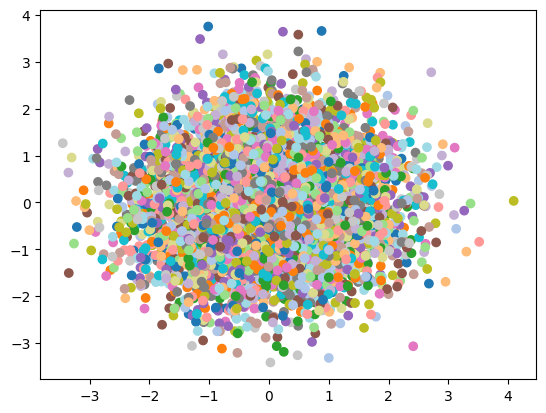

In [14]:
visualize_latent_space(gesture_vae, val_loader, device)

In [15]:
@torch.no_grad()
def validate(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0
    for batch in val_loader:
        true_labels = batch[1]
        batch = batch[0]
        batch = batch.to(device)
        scores, _, _ = model(batch)
        scores = scores.cpu()
        _, pred_labels = torch.max(scores, 1)
        total += true_labels.shape[0]
        correct += (pred_labels == true_labels).sum().item()
    return correct / total

In our training loop, we try to prevent overfitting by validating the model on a heldout gestures set.

In [16]:
def train(model, train_loader, val_loader, optimizer, num_epochs, device, scheduler=None, beta=1, verbose=1):
    val_history = np.zeros(num_epochs)
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for i, batch in enumerate(train_loader):
            labels = batch[1].to(device)
            batch = batch[0]
            batch = batch.to(device)
            batch_rec, mu, log_var = model(batch)
            loss = loss_function(batch_rec, labels, mu, log_var, beta=beta)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            if scheduler:
                scheduler.step(epoch + i / len(train_loader))

        val_acc = validate(model, val_loader, device)
        val_history[epoch] = val_acc

        epoch_loss /= len(train_loader)
        if epoch % verbose == 0:
            print(f'Epoch: {epoch}, train loss: {epoch_loss}, val acc: {val_acc}')
    return model, val_history

In [17]:
# Running the training loop

gesture_vae, val_history = train(gesture_vae, train_loader, val_loader, optimizer, 300, device, scheduler, beta=1)

Epoch: 0, train loss: 2.9258929270285146, val acc: 0.05627900014967819
Epoch: 1, train loss: 2.899236935156363, val acc: 0.06136805867385122
Epoch: 2, train loss: 2.8847189479404025, val acc: 0.0719952102978596
Epoch: 3, train loss: 2.863413024831701, val acc: 0.06750486454123635
Epoch: 4, train loss: 2.8316905675110995, val acc: 0.07992815446789403
Epoch: 5, train loss: 2.79659366607666, val acc: 0.09534500823230055
Epoch: 6, train loss: 2.7569571424413613, val acc: 0.07603652147882053
Epoch: 7, train loss: 2.7376141724763094, val acc: 0.09878760664571172
Epoch: 8, train loss: 2.7120708889431424, val acc: 0.1122586439155815
Epoch: 9, train loss: 2.687177154752943, val acc: 0.09803921568627451
Epoch: 10, train loss: 2.6722648055465132, val acc: 0.10103277952402336
Epoch: 11, train loss: 2.6621865696377225, val acc: 0.10597215985630894
Epoch: 12, train loss: 2.6482199562920465, val acc: 0.10537344708875916
Epoch: 13, train loss: 2.6395204773655645, val acc: 0.1261787157611136
Epoch: 14,

Now, let's see how the embeddings from the validation set look like *after* training.

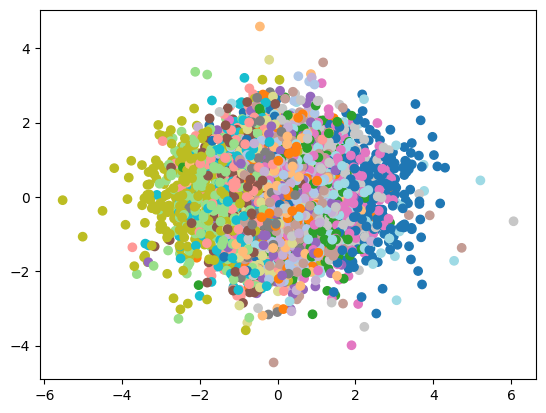

In [24]:
visualize_latent_space(gesture_vae, val_loader, device)

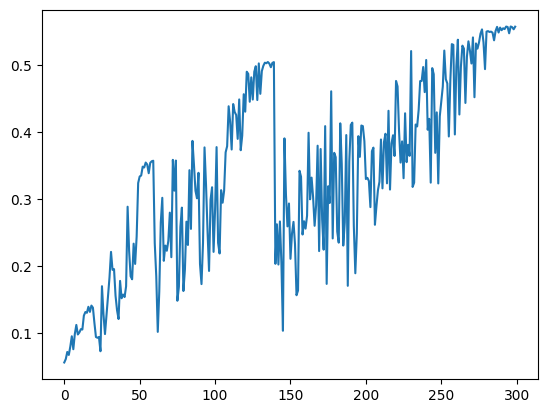

In [25]:
plt.plot(val_history)

## Exporting Model

Finally, we export the gesture encoder as a TorchScript model.

In [26]:
gesture_vae.eval()
scripted_encoder = torch.jit.script(gesture_vae.encoder.to('cpu'))

In [27]:
scripted_encoder.save('gesture_encoder.ts')

In [28]:
scripted_encoder = torch.jit.load("gesture_encoder.ts").eval()

In [29]:
%timeit scripted_encoder(torch.randn(1, 420))

172 µs ± 31.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
